# Aprendizado profundo com Python

## 6.3 Uso avançado de redes neurais recorrentes

> Uso avançado de rede neural recorrente

Agora, usamos um exemplo para entender várias técnicas de redes neurais recorrentes: dropout de loop, camadas de loop empilhado, camadas de loop bidirecional.

### Problema de previsão de temperatura

Usaremos um conjunto de dados de série temporal do tempo registrado por uma estação meteorológica. Nesse conjunto de dados, há 14 quantidades (como temperatura, pressão do ar, umidade, direção do vento, etc.) registradas a cada 10 minutos. Este conjunto de dados tem muitos anos de registros. Aqui, usamos apenas os anos de 2009-2016. Use este conjunto de dados para construir um modelo. O objetivo final é inserir alguns dados recentes (alguns dias de pontos de dados) para prever a temperatura nas próximas 24 horas.

Primeiro, baixe e descompacte este conjunto de dados:


`` `sh
cd ~ / em algum lugar
mkdir jena_climate
cd jena_climate
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
descompacte jena_climate_2009_2016.csv.zip
`` `

Dê uma olhada nos dados:Treine e avalie um modelo baseado em GRU usando regularização de abandono

Antes de mais nada os notebooks aqui mostrado tiveram como base/foram retirados dos seguintes repositórios: 
 > https://github.com/fchollet/deep-learning-with-python-notebooks 
 
 
 > https://github.com/cdfmlr/Deep-Learning-with-Python-Notebooks
 
 Sugiro fortemente que consultem os códigos originais e em caso de dúvida podem me contatar para conversarmos. 

In [2]:
Antes de mais nada os notebooks aqui mostrado tiveram como base/foram retirados dos seguintes repositórios: 
 > https://github.com/fchollet/deep-learning-with-python-notebooks 
 
 
 > https://github.com/cdfmlr/Deep-Learning-with-Python-Notebooks
 
 Sugiro fortemente que consultem os códigos originais e em caso de dúvida podem me contatar para conversarmos. import os

data_dir = "...dataset/jena_climate"
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))
print(lines[0])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30


Coloque os dados em uma matriz Numpy:

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header)-1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
print(float_data.shape)

(420551, 14)


Nós desenhamos as mudanças de temperatura, a periodicidade é óbvia:

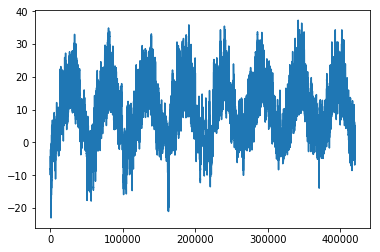

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

Nós desenhamos as mudanças de temperatura, a periodicidade é óbvia:Nós desenhamos as mudanças de temperatura, a periodicidade é óbvia:

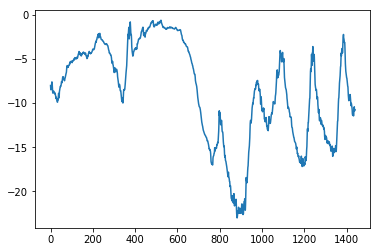

In [5]:
plt.plot(range(1440), temp[: 1440])

Esta foto mostra que é inverno, e as mudanças diárias de temperatura também são periódicas (mais óbvias nos próximos dias).

A próxima etapa é tentar fazer o trabalho do modelo preditivo. Primeiro, vamos esclarecer nosso problema: dados os passos de tempo `lookback` anteriores (a cada 10 minutos), não amostramos uma vez com` passos`, para que você possa prever a temperatura futura em passos de tempo de `delay`:

-`lookback = 720`: Dados de observação dos últimos 5 dias
-`steps = 6`: Os dados de observação são amostrados a cada hora
-`delay = 144`: A meta são as próximas 24 horas

**preparação de dados**

1. Padronização de dados: faça a diferença no número de vários recursos pequenos

In [6]:
# Padronização de dados

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

2. Coloque os dados em um gerador, rendimento `(amostras, alvos)`, amostras é o lote de dados de entrada, alvos é a matriz de temperatura alvo correspondente.

In [7]:
# Gerador que gera amostras de séries temporais e seus alvos

def generator(data,     # Dados não tratados
              lookback, # Quantas etapas de tempo estão incluídas nos dados de entrada
              delay,    # Quantos passos de tempo a meta está no futuro
              min_index, max_index,  # Especifique a parte dos dados a extrair
              shuffle=False,   # Misture a amostra ou retire em ordem
              batch_size=128,  # Número de amostras por lote
              step=6):         # Período de amostragem de dados
    
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

Chame este gerador para instanciar o gerador de conjunto de treinamento, gerador de conjunto de validação e gerador de conjunto de teste:

In [8]:
# Prepare gerador de treinamento, gerador de verificação e gerador de teste
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, 
                      lookback=lookback, 
                      delay=delay, 
                      min_index=0, 
                      max_index=200000, 
                      shuffle=True, 
                      step=step, 
                      batch_size=batch_size)

val_gen = generator(float_data, 
                    lookback=lookback, 
                    delay=delay, 
                    min_index=200001, 
                    max_index=300000, 
                    step=step, 
                    batch_size=batch_size)

test_gen = generator(float_data, 
                     lookback=lookback, 
                     delay=delay, 
                     min_index=300001, 
                     max_index=None, 
                     step=step, 
                     batch_size=batch_size)

# Quantas vezes são necessárias para verificação e teste:
val_steps = (300000 - 200001 - lookback)  // batch_size
test_steps = (len(float_data) - 300001 - lookback)  // batch_size

** Um método comparativo de aprendizado sem máquina de bom senso **

Assumimos que a série temporal de temperatura é contínua e que a temperatura diária muda periodicamente. Nesse caso, você pode assumir ousadamente que a temperatura nas próximas 24 horas é igual à temperatura atual.

Usamos o método de aprendizado sem máquina baseado no bom senso como referência e usamos o erro médio absoluto (MAE) como um indicador para avaliá-lo e medi-lo:

`` `python
mae = np.mean (np.abs (preds-targets))
`` `

O modelo de aprendizado de máquina que faremos posteriormente deve exceder esse comparativo para mostrar que o aprendizado de máquina é eficaz.

In [9]:
# Calcular MAE com base no método de benchmark de senso comum

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    
    return np.mean(batch_maes)
    
mae = evaluate_naive_method()
celsius_mae = mae * std[1]
print(f'mae={mae}, Erro médio absoluto de temperatura={celsius_mae}°C')

mae=0.2897359729905486, 温度的平均绝对误差=2.564887434980494°C


Esse erro ainda é relativamente grande, então a próxima meta é usar o aprendizado profundo para superar esse benchmark.

** Métodos básicos de aprendizado de máquina **

Antes de usar redes complexas e computacionalmente caras (como RNN), é melhor tentar um modelo simples para resolver o problema.

Então, aqui, primeiro usamos uma rede simples totalmente conectada para tentar lidar com o problema da previsão do tempo:

In [9]:
# Desenhe a história

import matplotlib.pyplot as plt

def plot_acc_and_loss(history):

    epochs = range(len(history.history['loss']))

    try:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        
        plt.plot(epochs, acc, 'bo-', label='Training acc')
        plt.plot(epochs, val_acc, 'rs-', label='Validation acc')
        plt.title('Training and validation accuracy')
        plt.legend()
    except:
        print('No acc. Skip')
    finally:
        plt.figure()

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'rs-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 10s 20ms/step - loss: 1.7705 - val_loss: 1.0356
Epoch 2/20
500/500 [==============================] - 11s 21ms/step - loss: 0.5680 - val_loss: 0.3472
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.3088 - val_loss: 0.3306
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2708 - val_loss: 0.3071
Epoch 5/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2583 - val_loss: 0.3039
Epoch 6/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2473 - val_loss: 0.3599
Epoch 7/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2397 - val_loss: 0.3165
Epoch 8/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2343 - val_loss: 0.3205
Epoch 9/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2298 - val_loss: 0.3167
Epoch 

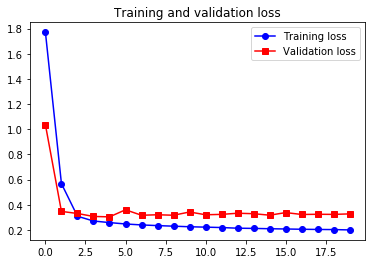

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

plot_acc_and_loss(history)

Embora parte desse resultado exceda o método de benchmark sem aprendizado de máquina, não é confiável o suficiente. Na verdade, não é fácil superar o método de benchmark baseado em teste. Nosso teste contém muitas informações úteis que são difíceis para as máquinas aprenderem. De modo geral, para esse tipo de solução simples e eficiente, a menos que codifiquemos o modelo para usar esse método simples, é difícil encontrar esse modelo simples e melhorá-lo ainda, dependendo da máquina para aprender os parâmetros.

** Comparativo de mercado da rede circular **

A rede totalmente conectada agora usa um Flatten para nivelar a série temporal desde o início, de forma que o modelo realmente não considere o conceito de "tempo". Para usar a ordem do tempo, podemos considerar o uso de uma rede recorrente. Desta vez, usaremos a camada GRU em vez de LSTM:

Epoch 1/20
500/500 [==============================] - 58s 116ms/step - loss: 0.3069 - val_loss: 0.2687
Epoch 2/20
500/500 [==============================] - 56s 113ms/step - loss: 0.2850 - val_loss: 0.2692
Epoch 3/20
500/500 [==============================] - 56s 112ms/step - loss: 0.2765 - val_loss: 0.2704
Epoch 4/20
500/500 [==============================] - 57s 114ms/step - loss: 0.2708 - val_loss: 0.2624
Epoch 5/20
500/500 [==============================] - 57s 115ms/step - loss: 0.2694 - val_loss: 0.2677
Epoch 6/20
500/500 [==============================] - 58s 115ms/step - loss: 0.2624 - val_loss: 0.2604
Epoch 7/20
500/500 [==============================] - 59s 118ms/step - loss: 0.2548 - val_loss: 0.2646
Epoch 8/20
500/500 [==============================] - 60s 119ms/step - loss: 0.2527 - val_loss: 0.2656
Epoch 9/20
500/500 [==============================] - 62s 124ms/step - loss: 0.2494 - val_loss: 0.2691
Epoch 10/20
500/500 [==============================] - 62s 124ms/step - l

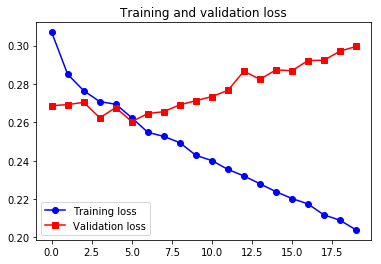

In [13]:
# Treine e avalie um modelo baseado em GRU

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=20, 
                              validation_data=val_gen, 
                              validation_steps=val_steps)

plot_acc_and_loss(history)

Antes de iniciar o overfitting, o erro de temperatura do melhor resultado é:

In [17]:
print(0.2624 * std[1], '°C')

2.3228957591704926 °C


Melhor do que o modelo de bom senso no início. Mas vemos que o sobreajuste é feito mais tarde.No RNN, podemos usar a perda de loop para combater o sobreajuste.

** Loop dropout **

Usamos dropout na rede feedforward, que é para definir a unidade de entrada de uma determinada camada para 0 aleatoriamente. Mas não é tão simples em RNNs. Usar dropout antes da camada de loop apenas atrapalhará o aprendizado, mas não ajudará no resultado, então use droput na camada de loop.

O uso de dropout na camada de loop deve usar a mesma máscara (máscara, ou seja, unidade de descarte) para cada timestep, e a máscara não pode ser diferente com o timestep. Ao mesmo tempo, para camadas cíclicas como LSTM e GRU, uma "máscara de exclusão cíclica" que não muda com o tempo é aplicada ao ciclo interno de ativação da camada. Ambas as implementações de dropout são construídas na camada de loop de Keras. Você só precisa especificar a taxa de dropout por meio dos parâmetros `dropout` e` recurrent_dropout`.

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
500/500 [==============================] - 101s 202ms/step - loss: 0.3491 - val_loss: 0.2865
Epoch 2/40
500/500 [==============================] - 90s 180ms/step - loss: 0.3200 - val_loss: 0.2826
Epoch 3/40
500/500 [==============================] - 93s 185ms/step - loss: 0.3127 - val_loss: 0.2825
Epoch 4/40
500/500 [==============================] - 92s 183ms/step - loss: 0.3074 - val_loss: 0.2783
Epoch 5/40
500/500 [==============================] - 92s 183ms/step - loss: 0.3046 - val_loss: 0.2757
Epoch 6/40
500/500 [==============================] - 90s 179ms/step - loss: 0.2987 - val_loss: 0.2797
Epoch 7/40
500/500 [==============================] - 89s 179ms/step - loss: 0.2950 - val_loss: 0.2886
Epoch 8/40
500/500 [==============================] - 90s 180ms/step - loss: 0.2891 - val_loss: 0.2837
Epoch 9/40
500/500 [==============================] - 90s 179ms/step - loss: 0.2851 - val_loss: 0.2

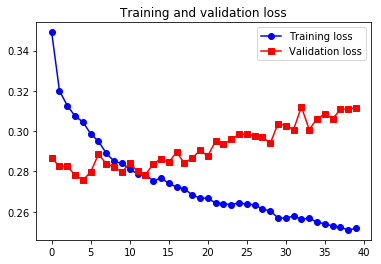

In [10]:
# Treine e avalie um modelo baseado em GRU usando regularização de abandono

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.4, 
                     recurrent_dropout=0.4, 
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500, 
                              epochs=40,    # Redes que usam abandono demoram mais para convergir
                              validation_data=val_gen, 
                              validation_steps=val_steps)

plot_acc_and_loss(history)

Isso não é tão bom quanto o livro, não sei por quê.

** Empilhamento de camada circular **

O problema de overfitting foi resolvido e agora a precisão deve ser melhorada. Apenas uma camada cíclica foi usada agora. Você pode considerar adicionar mais algumas e empilhá-las para aumentar a capacidade da rede. Na verdade, o empilhamento de camadas cíclicas não requer muito empilhamento, e o Google Translate usa apenas 7 camadas LSTM supergrandes empilhadas juntas.

Empilhe as camadas de loop em Keras, lembre-se de que a camada do meio deve retornar o tensor de sequência de saída 3D completo, não apenas a saída da última etapa de tempo (este comportamento é o padrão):

Epoch 1/40
500/500 [==============================] - 225s 450ms/step - loss: 0.3214 - val_loss: 0.2784
Epoch 2/40
500/500 [==============================] - 229s 459ms/step - loss: 0.3029 - val_loss: 0.2721
Epoch 3/40
500/500 [==============================] - 247s 494ms/step - loss: 0.2925 - val_loss: 0.2747
Epoch 4/40
500/500 [==============================] - 265s 531ms/step - loss: 0.2877 - val_loss: 0.2684
Epoch 5/40
500/500 [==============================] - 279s 558ms/step - loss: 0.2791 - val_loss: 0.2749
Epoch 6/40
500/500 [==============================] - 294s 588ms/step - loss: 0.2747 - val_loss: 0.2691
Epoch 7/40
500/500 [==============================] - 297s 593ms/step - loss: 0.2689 - val_loss: 0.2816
Epoch 8/40
500/500 [==============================] - 251s 501ms/step - loss: 0.2649 - val_loss: 0.2779
Epoch 9/40
500/500 [==============================] - 242s 485ms/step - loss: 0.2586 - val_loss: 0.2754
Epoch 10/40
500/500 [==============================] - 245s 489m

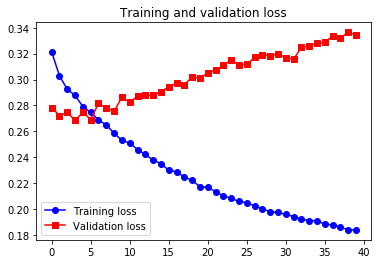

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,  # Saída sequência de saída completa
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

plot_acc_and_loss(history)

Isso também é diferente do livro. Mas pode ser visto que as camadas de loop de empilhamento não trazem muita melhoria de desempenho.

** Use RNN bidirecional **

RNNs bidirecionais (redes bidirecionais recorrentes) são variantes de RNNs, que às vezes podem ter um desempenho melhor do que RNNs, especialmente no processamento de linguagem natural. RNNs bidirecionais são chamados de Swiss Army of Deep Learning NLP.

O RNN depende do tempo da sequência ou de outra ordem. Se o intervalo de tempo for embaralhado ou invertido, a representação que o RNN extrai da sequência é completamente diferente. Aproveitando a sensibilidade do RNN à ordem, o RNN bidirecional contém dois RNNs comuns, que processam a sequência de entrada na ordem positiva e reversa, e finalmente combinam as representações que aprenderam, de modo que seja possível aprender a ser um RNN unidirecional Modo ignorado.

Antes, treinávamos em ordem cronológica por padrão, agora podemos tentar processar na ordem inversa. Para inverter a ordem, basta enviar na última direção do gerador de dados `amostras de rendimento [:, :: - 1,:], destinos)`:

In [12]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)

val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

Epoch 1/20
500/500 [==============================] - 61s 121ms/step - loss: 0.4796 - val_loss: 0.4788
Epoch 2/20
500/500 [==============================] - 58s 117ms/step - loss: 0.4488 - val_loss: 0.4791
Epoch 3/20
500/500 [==============================] - 63s 125ms/step - loss: 0.3956 - val_loss: 0.4613
Epoch 4/20
500/500 [==============================] - 59s 118ms/step - loss: 0.3605 - val_loss: 0.4170
Epoch 5/20
500/500 [==============================] - 60s 121ms/step - loss: 0.3400 - val_loss: 0.3806
Epoch 6/20
500/500 [==============================] - 66s 131ms/step - loss: 0.3145 - val_loss: 0.3766
Epoch 7/20
500/500 [==============================] - 64s 128ms/step - loss: 0.2948 - val_loss: 0.3513
Epoch 8/20
500/500 [==============================] - 63s 126ms/step - loss: 0.2795 - val_loss: 0.3469
Epoch 9/20
500/500 [==============================] - 65s 129ms/step - loss: 0.2701 - val_loss: 0.3365
Epoch 10/20
500/500 [==============================] - 62s 124ms/step - l

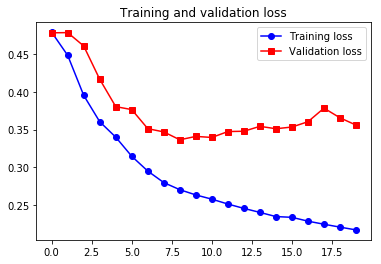

In [14]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)
plot_acc_and_loss(history)

Este efeito não é bom. Este é o caso. Para a previsão da temperatura, é claro, os dados recentes são mais úteis, enquanto as informações de muito tempo atrás são pouco significativas. À medida que os passos de tempo progridem, a camada cíclica perderá algumas informações antigas, então esse problema é comparado com o resultado da ordem positiva. Os resultados da ordem inversa são bons.

Mas, para o processamento de informações de texto, a importância de uma palavra para a compreensão da frase geralmente não depende de sua posição na frase. Em outras palavras, embora a ordem das palavras seja importante para a compreensão do idioma, não importa a ordem usada. Portanto, ao lidar com alguns problemas de texto, a ordem positiva e inversa podem obter resultados muito semelhantes:

Epoch 1/10
157/157 [==============================] - 53s 339ms/step - loss: 0.4945 - acc: 0.7638 - val_loss: 0.4783 - val_acc: 0.8256
Epoch 2/10
157/157 [==============================] - 54s 345ms/step - loss: 0.3198 - acc: 0.8755 - val_loss: 0.5395 - val_acc: 0.7596
Epoch 3/10
157/157 [==============================] - 54s 346ms/step - loss: 0.2566 - acc: 0.9046 - val_loss: 0.3488 - val_acc: 0.8586
Epoch 4/10
157/157 [==============================] - 54s 346ms/step - loss: 0.2130 - acc: 0.9245 - val_loss: 0.3651 - val_acc: 0.8726
Epoch 5/10
157/157 [==============================] - 54s 344ms/step - loss: 0.1923 - acc: 0.9336 - val_loss: 0.3638 - val_acc: 0.8818
Epoch 6/10
157/157 [==============================] - 53s 341ms/step - loss: 0.1662 - acc: 0.9435 - val_loss: 0.4075 - val_acc: 0.8764
Epoch 7/10
157/157 [==============================] - 53s 341ms/step - loss: 0.1461 - acc: 0.9489 - val_loss: 0.3723 - val_acc: 0.8798
Epoch 8/10
157/157 [==============================] - 5

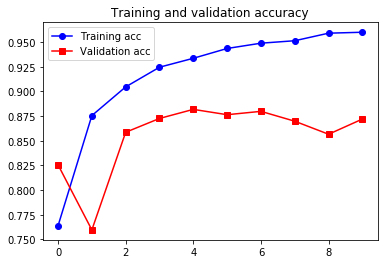

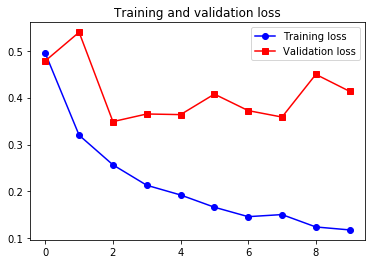

In [17]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)
plot_acc_and_loss(history)

O resultado IMDB desse treinamento de ordem reversa não é muito diferente da ordem positiva.

Se combinarmos a ordem positiva e a ordem reversa, visualizarmos os dados de diferentes perspectivas e complementarmos um ao outro com conteúdo negligenciado, é possível melhorar o desempenho do modelo. Isso é o que o RNN bidirecional faz.

! [O princípio de funcionamento da camada RNN bidirecional] (https://tva1.sinaimg.cn/large/007S8ZIlgy1ghmsndu024j311s0jejtx.jpg)

Em Keras, a camada bidirecional é usada para implementar RNN bidirecional:

Epoch 1/10
157/157 [==============================] - 50s 317ms/step - loss: 0.5840 - acc: 0.6994 - val_loss: 0.4705 - val_acc: 0.7818
Epoch 2/10
157/157 [==============================] - 45s 285ms/step - loss: 0.3490 - acc: 0.8637 - val_loss: 0.4346 - val_acc: 0.7974
Epoch 3/10
157/157 [==============================] - 44s 283ms/step - loss: 0.2682 - acc: 0.8992 - val_loss: 0.6617 - val_acc: 0.7542
Epoch 4/10
157/157 [==============================] - 44s 283ms/step - loss: 0.2263 - acc: 0.9189 - val_loss: 0.3449 - val_acc: 0.8794
Epoch 5/10
157/157 [==============================] - 45s 285ms/step - loss: 0.1988 - acc: 0.9301 - val_loss: 0.4799 - val_acc: 0.8106
Epoch 6/10
157/157 [==============================] - 45s 286ms/step - loss: 0.1832 - acc: 0.9366 - val_loss: 0.4068 - val_acc: 0.8378
Epoch 7/10
157/157 [==============================] - 46s 293ms/step - loss: 0.1710 - acc: 0.9420 - val_loss: 0.3501 - val_acc: 0.8768
Epoch 8/10
157/157 [==============================] - 4

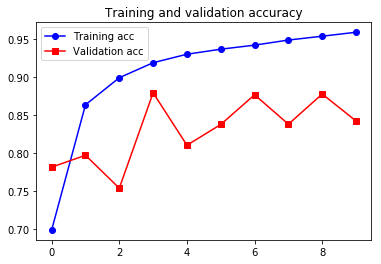

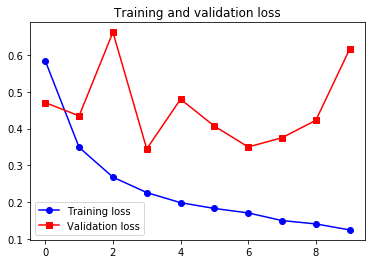

In [18]:
# Treine e avalie um LSTM bidirecional no IMDB

model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

plot_acc_and_loss(history)

A seguir, tentamos aplicar o método RNN bidirecional às tarefas de previsão de temperatura.

Epoch 1/40
500/500 [==============================] - 81s 163ms/step - loss: 0.3022 - val_loss: 0.2796
Epoch 2/40
500/500 [==============================] - 76s 151ms/step - loss: 0.2761 - val_loss: 0.2619
Epoch 3/40
500/500 [==============================] - 76s 152ms/step - loss: 0.2699 - val_loss: 0.2671
Epoch 4/40
500/500 [==============================] - 76s 151ms/step - loss: 0.2630 - val_loss: 0.2625
Epoch 5/40
500/500 [==============================] - 76s 152ms/step - loss: 0.2584 - val_loss: 0.2744
Epoch 6/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2537 - val_loss: 0.2726
Epoch 7/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2464 - val_loss: 0.2713
Epoch 8/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2416 - val_loss: 0.2783
Epoch 9/40
500/500 [==============================] - 79s 158ms/step - loss: 0.2370 - val_loss: 0.2787
Epoch 10/40
500/500 [==============================] - 78s 156ms/step - l

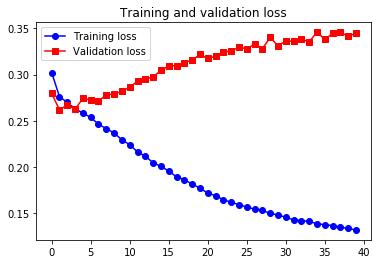

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)
plot_acc_and_loss(history)

** Indo ainda mais longe **

Em seguida, você pode tentar:

-Aumente o número de unidades na camada
-Ajuste a taxa de aprendizagem do RMSprop
-Tente substituir a camada GRU pela camada LSTM
- Use um regressor de conexão densa maior acima (atrás) da camada de loop (camada Densa maior ou pilha de camadas Densa)
- Execute o modelo de melhor desempenho no conjunto de teste para evitar que o modelo super ajuste o conjunto de validação